# Topology

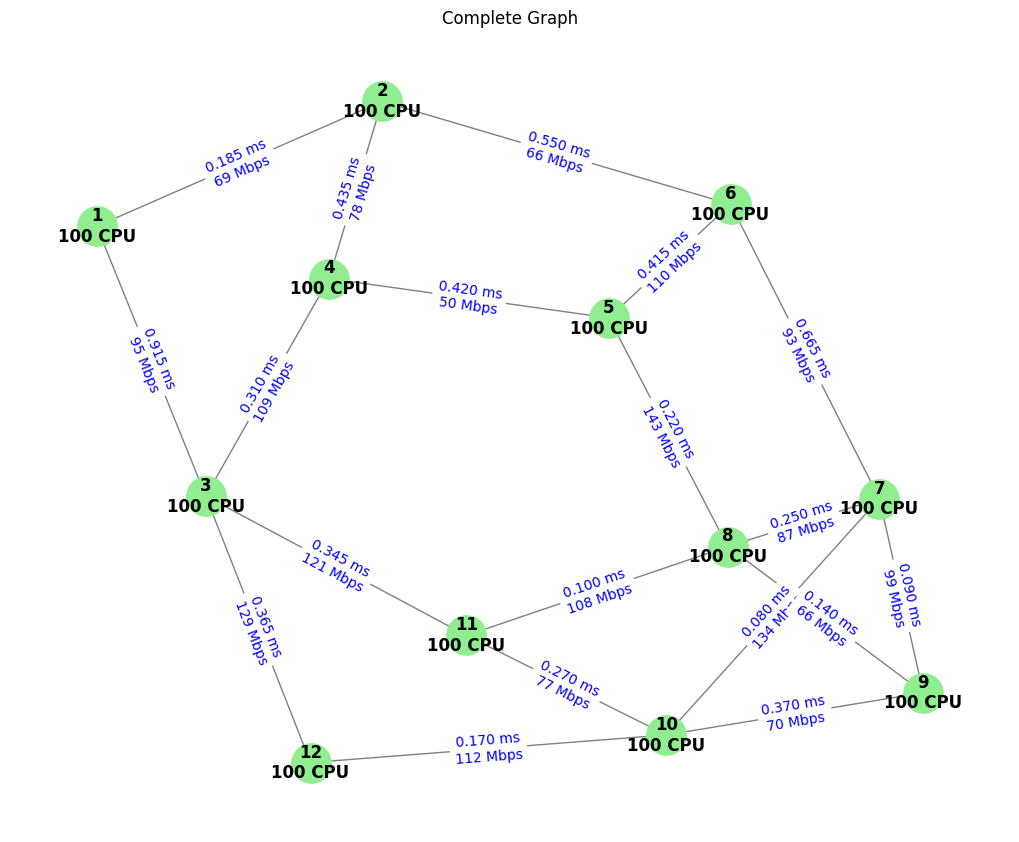

In [1]:
from topology import generate_complete_graph, draw_graph, topologie_finlande

G = topologie_finlande()
draw_graph(G)


# Slicing Generation

In [2]:
from generate_slices import generate_random_slices, vnf_profiles
import pandas as pd

# Generate the slices
slices = generate_random_slices(G, vnf_profiles, 6)

# Convert to readable table
slices_data = []
for i, (vnfs, vls) in enumerate(slices):
    slices_data.append({
        "Slice": i + 1,
        "VNF IDs": [v["id"] for v in vnfs],
        "VNF CPUs": [v["cpu"] for v in vnfs],
        "VL Pairs": [(vl["from"], vl["to"]) for vl in vls],
        "VL Bandwidths": [vl["bandwidth"] for vl in vls],
        "VL Latencies": [vl["latency"] for vl in vls]
    })

df_slices = pd.DataFrame(slices_data)
df_slices


,Slice,VNF IDs,VNF CPUs,VL Pairs,VL Bandwidths,VL Latencies
0,1,"[vnf0_0, vnf0_1, vnf0_2]","[8, 8, 8]","[(vnf0_0, vnf0_1), (vnf0_1, vnf0_2)]","[150, 150]","[35, 57]"
1,2,"[vnf1_0, vnf1_1, vnf1_2]","[4, 2, 4]","[(vnf1_0, vnf1_1), (vnf1_1, vnf1_2)]","[100, 80]","[97, 22]"
2,3,"[vnf2_0, vnf2_1, vnf2_2]","[6, 4, 2]","[(vnf2_0, vnf2_1), (vnf2_1, vnf2_2)]","[120, 100]","[26, 36]"
3,4,"[vnf3_0, vnf3_1, vnf3_2]","[2, 2, 2]","[(vnf3_0, vnf3_1), (vnf3_1, vnf3_2)]","[80, 80]","[44, 87]"
4,5,"[vnf4_0, vnf4_1, vnf4_2]","[2, 2, 6]","[(vnf4_0, vnf4_1), (vnf4_1, vnf4_2)]","[80, 80]","[32, 61]"
5,6,"[vnf5_0, vnf5_1, vnf5_2]","[6, 4, 6]","[(vnf5_0, vnf5_1), (vnf5_1, vnf5_2)]","[120, 100]","[37, 90]"


In [3]:
from run_abo_full_batch import run_abo_full_batch
from a_star import run_astar
from run_fabo_full_batch import run_fabo_full_batch
from first_fit import run_first_fit

# Define base capacities
node_capacity_base = {node: 10 for node in G.nodes}
link_latency = {(u, v): G[u][v]['latency'] for u, v in G.edges}
link_latency.update({(v, u): lat for (u, v), lat in link_latency.items()})
link_capacity_base = {(u, v): G[u][v]['bandwidth'] for u, v in G.edges}
link_capacity_base.update({(v, u): bw for (u, v), bw in link_capacity_base.items()})

# Run ABO
df_abo, abo_results = run_abo_full_batch(
    G,
    slices,
    node_capacity_base.copy(),
    link_latency,
    link_capacity_base.copy()
)

# Run FF
df_ff, ff_results, _ = run_first_fit(
    G,
    slices,
    node_capacity_base.copy()
)

# Run A*
df_astar, astar_results = run_astar(
    G,
    slices,
    node_capacity_base.copy(),
    link_latency,
    link_capacity_base.copy()
)

# Run FABO
df_fabo, fabo_results = run_fabo_full_batch(
    G,
    slices,
    node_capacity_base.copy(),
    link_latency,
    link_capacity_base.copy()
)

# Print summaries
print("ABO Results:\n", df_abo)
print("FF Results:\n", df_ff)
print("A* Results:\n", df_astar)
print("FABO Results:\n", df_fabo)


Attempting to route VL (vnf0_0, vnf0_1) from node 1 to 2
→ Path: [1, 2], latency: 37ms, max allowed: 150ms
Attempting to route VL (vnf0_0, vnf0_1) from node 1 to 3
→ Path: [1, 3], latency: 183ms, max allowed: 150ms
Attempting to route VL (vnf0_0, vnf0_1) from node 1 to 4
→ Path: [1, 2, 4], latency: 124ms, max allowed: 150ms
Attempting to route VL (vnf0_0, vnf0_1) from node 1 to 5
→ Path: [1, 2, 4, 5], latency: 208ms, max allowed: 150ms
Attempting to route VL (vnf0_0, vnf0_1) from node 1 to 6
→ Path: [1, 2, 6], latency: 147ms, max allowed: 150ms
Attempting to route VL (vnf0_0, vnf0_1) from node 1 to 7
→ Path: [1, 2, 6, 7], latency: 280ms, max allowed: 150ms
Attempting to route VL (vnf0_0, vnf0_1) from node 1 to 8
→ Path: [1, 2, 4, 5, 8], latency: 252ms, max allowed: 150ms
Attempting to route VL (vnf0_0, vnf0_1) from node 1 to 9
→ Path: [1, 2, 4, 5, 8, 9], latency: 280ms, max allowed: 150ms
Attempting to route VL (vnf0_0, vnf0_1) from node 1 to 10
→ Path: [1, 3, 12, 10], latency: 290ms, 

Running FABO: 100%|██████████| 6/6 [00:00<00:00, 362.20slice/s]

ABO Results:
    slice  accepted  g_cost
0      1      True     240
1      2      True     200
2      3      True     200
3      4      True     200
4      5      True     200
5      6      True     240
FF Results:
    slice  accepted  g_cost
0      1      True       0
1      2      True       0
2      3      True       0
3      4      True     149
4      5      True       0
5      6      True     183
A* Results:
    slice  accepted  g_cost
0      1      True     240
1      2      True     200
2      3      True     200
3      4      True     200
4      5      True     200
5      6      True     240
FABO Results:
    slice  accepted  g_cost
0      1      True   240.0
1      2      True   200.0
2      3      True   200.0
3      4      True   200.0
4      5      True   200.0
5      6      True   240.0


In [4]:
import pandas as pd

def get_vnfs_per_node(result_list):
    # Coletamos todos os pares (node, vnf_id) de todos os resultados aceitos
    allocations = []
    for slice_idx, result in enumerate(result_list):
        if result is None:
            continue
        for vnf_id, node in result.placed_vnfs.items():
            allocations.append({"slice": slice_idx + 1, "node": node, "vnf": vnf_id})

    df = pd.DataFrame(allocations)
    return df.sort_values(by=["node", "slice", "vnf"]).reset_index(drop=True)

# Exemplo de uso com resultados do A*
vnfs_per_node = get_vnfs_per_node(abo_results)
vnfs_per_node


,slice,node,vnf
0,2,1,vnf1_0
1,3,1,vnf2_0
2,4,1,vnf3_0
3,6,1,vnf5_0
4,2,4,vnf1_1
5,3,4,vnf2_1
6,4,4,vnf3_1
7,6,4,vnf5_1
8,2,5,vnf1_2
9,3,5,vnf2_2


In [5]:
# Recreate the DataFrame from stored slices (reconstruct summary if needed)
abo_summary = []
for i, result in enumerate(abo_results):
    abo_summary.append({
        "slice": i + 1,
        "accepted": result is not None,
        "g_cost": result.g_cost if result else None
    })

# Compute metrics
accepted_costs = [entry["g_cost"] for entry in abo_summary if entry["accepted"]]
average_g_cost = sum(accepted_costs) / len(accepted_costs)
min_g_cost = min(accepted_costs)
max_g_cost = max(accepted_costs)

# Display metrics
{
    "Average g_cost (Mbps)": average_g_cost,
    "Min g_cost (Mbps)": min_g_cost,
    "Max g_cost (Mbps)": max_g_cost,
    "Total slices": len(abo_summary),
    "Accepted slices": len(accepted_costs),
    "Acceptance rate (%)": (len(accepted_costs) / len(abo_summary)) * 100
}


{'Average g_cost (Mbps)': 200.0,
 'Min g_cost (Mbps)': 160,
 'Max g_cost (Mbps)': 240,
 'Total slices': 6,
 'Accepted slices': 6,
 'Acceptance rate (%)': 100.0}

In [6]:
import pandas as pd
vnf_placement_data = []

for slice_index, result in enumerate(abo_results):
    if result is not None:
        for vnf_id, node in result.placed_vnfs.items():
            vnf_placement_data.append({
                "Slice": slice_index + 1,
                "VNF": vnf_id,
                "Node": node
            })

df_placement = pd.DataFrame(vnf_placement_data)
df_placement = df_placement.sort_values(by=["Slice", "VNF"])
df_placement


,Slice,VNF,Node
0,1,vnf0_0,6
1,1,vnf0_1,10
2,1,vnf0_2,11
3,2,vnf1_0,1
4,2,vnf1_1,4
5,2,vnf1_2,5
6,3,vnf2_0,1
7,3,vnf2_1,4
8,3,vnf2_2,5
9,4,vnf3_0,1


In [7]:
vl_routing_data = []

for slice_index, result in enumerate(abo_results):
    if result is not None:
        for (src, dst), path in result.routed_vls.items():
            vl_routing_data.append({
                "Slice": slice_index + 1,
                "VL": f"{src} → {dst}",
                "Path": " → ".join(str(n) for n in path)
            })

df_routing = pd.DataFrame(vl_routing_data)
df_routing


,Slice,VL,Path
0,1,vnf0_0 → vnf0_1,6 → 7 → 10
1,1,vnf0_1 → vnf0_2,10 → 11
2,2,vnf1_0 → vnf1_1,1 → 2 → 4
3,2,vnf1_1 → vnf1_2,4 → 5
4,3,vnf2_0 → vnf2_1,1 → 2 → 4
5,3,vnf2_1 → vnf2_2,4 → 5
6,4,vnf3_0 → vnf3_1,1 → 2 → 4
7,4,vnf3_1 → vnf3_2,4 → 5
8,5,vnf4_0 → vnf4_1,6 → 7 → 10
9,5,vnf4_1 → vnf4_2,10 → 11


# First-fit Orchestration 

In [8]:
from first_fit import run_first_fit

ff_df, ff_results, final_node_capacity = run_first_fit(G, slices, node_capacity)


In [9]:
ff_summary = []
for i, result in enumerate(ff_results):  
    ff_summary.append({
        "slice": i + 1,
        "accepted": result is not None,
        "g_cost": 0 if result else None 
    })

accepted_ff = [entry for entry in ff_summary if entry["accepted"]]

# Display metrics para First Fit
{
    "Average g_cost (Mbps)": None,
    "Min g_cost (Mbps)": None,
    "Max g_cost (Mbps)": None,
    "Total slices": len(ff_summary),
    "Accepted slices": len(accepted_ff),
    "Acceptance rate (%)": (len(accepted_ff) / len(ff_summary)) * 100
}


{'Average g_cost (Mbps)': None,
 'Min g_cost (Mbps)': None,
 'Max g_cost (Mbps)': None,
 'Total slices': 6,
 'Accepted slices': 6,
 'Acceptance rate (%)': 100.0}

In [10]:
for i, result in enumerate(ff_results):
    print(f"Slice {i+1}: {'Accepted' if result else 'Rejected'}")


Slice 1: Accepted
Slice 2: Accepted
Slice 3: Accepted
Slice 4: Accepted
Slice 5: Accepted
Slice 6: Accepted


In [11]:
final_node_capacity = node_capacity.copy()

for result in ff_results:
    if result:
        for vnf_id, node in result.placed_vnfs.items():
            cpu = next(
                vnf["cpu"]
                for vnf_chain, _ in slices
                for vnf in vnf_chain
                if vnf["id"] == vnf_id
            )
            final_node_capacity[node] -= cpu

print("Node capacity:")
for node, cap in final_node_capacity.items():
    print(f"Node {node}: {cap}")


Node capacity:
Node 1: 0
Node 2: 0
Node 3: 0
Node 4: 4
Node 5: 10
Node 6: 10
Node 7: 10
Node 8: 10
Node 9: 10
Node 10: 10
Node 11: 10
Node 12: 10


In [12]:
import pandas as pd

vnf_placement_data = []

for slice_index, result in enumerate(ff_results):
    if result is not None:
        for vnf_id, node in result.placed_vnfs.items():
            vnf_placement_data.append({
                "Slice": slice_index + 1,
                "VNF": vnf_id,
                "Node": node
            })

df_placement = pd.DataFrame(vnf_placement_data)
df_placement = df_placement.sort_values(by=["Slice", "VNF"])
df_placement


,Slice,VNF,Node
0,1,vnf0_0,1
1,1,vnf0_1,1
2,1,vnf0_2,1
3,2,vnf1_0,1
4,2,vnf1_1,2
5,2,vnf1_2,2
6,3,vnf2_0,2
7,3,vnf2_1,2
8,3,vnf2_2,2
9,4,vnf3_0,2


# A* 

In [13]:
from a_star import run_astar



df_astar, astar_results = run_astar(
    G,
    slices,
    node_capacity, 
    link_latency,
    link_capacity                 
)


print (df_astar)
print (astar_results)

   slice  accepted  g_cost
0      1      True     160
1      2      True     240
2      3      True     200
3      4      True     240
4      5      True     160
5      6      True     200
[<a_star.AStarState object at 0x7f85df2310d0>, <a_star.AStarState object at 0x7f85df213680>, <a_star.AStarState object at 0x7f85df233f80>, <a_star.AStarState object at 0x7f85df213c20>, <a_star.AStarState object at 0x7f85df231dc0>, <a_star.AStarState object at 0x7f85df211100>]


In [14]:
astar_summary = []
for i, result in enumerate(astar_results):  
    astar_summary.append({
        "slice": i + 1,
        "accepted": result is not None,
        "g_cost": 0 if result else None 
    })

accepted_astar = [entry for entry in astar_summary if entry["accepted"]]

# Display metrics para First Fit
{
    "Average g_cost (Mbps)": None,
    "Min g_cost (Mbps)": None,
    "Max g_cost (Mbps)": None,
    "Total slices": len(astar_summary),
    "Accepted slices": len(accepted_astar),
    "Acceptance rate (%)": (len(accepted_astar) / len(astar_summary)) * 100
}


{'Average g_cost (Mbps)': None,
 'Min g_cost (Mbps)': None,
 'Max g_cost (Mbps)': None,
 'Total slices': 6,
 'Accepted slices': 6,
 'Acceptance rate (%)': 100.0}

In [15]:
final_node_capacity = node_capacity.copy()

for result in astar_results:
    if result:
        for vnf_id, node in result.placed_vnfs.items():
            cpu = next(
                (vnf["cpu"]
                 for vnf_chain, _ in slices
                 for vnf in vnf_chain
                 if vnf["id"] == vnf_id),
                None
            )
            if cpu is None:
                print(f"[WARNING] VNF {vnf_id} not found in slice definitions.")
                continue
            final_node_capacity[node] -= cpu

print("Node capacity after all placements:")
for node, cap in final_node_capacity.items():
    print(f"Node {node}: {cap}")


Node capacity after all placements:
Node 1: 0
Node 2: 8
Node 3: 10
Node 4: 8
Node 5: 10
Node 6: 0
Node 7: 10
Node 8: 10
Node 9: 10
Node 10: 10
Node 11: 0
Node 12: 8


In [16]:
import pandas as pd

vnf_placement_data = []

for slice_index, result in enumerate(astar_results):
    if result is not None:
        for vnf_id, node in result.placed_vnfs.items():
            vnf_placement_data.append({
                "Slice": slice_index + 1,
                "VNF": vnf_id,
                "Node": node
            })

df_placement = pd.DataFrame(vnf_placement_data)
df_placement = df_placement.sort_values(by=["Slice", "VNF"])
df_placement


,Slice,VNF,Node
0,1,vnf0_0,1
1,1,vnf0_1,6
2,1,vnf0_2,11
3,2,vnf1_0,1
4,2,vnf1_1,6
5,2,vnf1_2,11
6,3,vnf2_0,1
7,3,vnf2_1,6
8,3,vnf2_2,11
9,4,vnf3_0,1


In [17]:
import pandas as pd
vnf_placement_data = []

for slice_index, result in enumerate(astar_results):
    if result is not None:
        for vnf_id, node in result.placed_vnfs.items():
            vnf_placement_data.append({
                "Slice": slice_index + 1,
                "VNF": vnf_id,
                "Node": node
            })

df_placement = pd.DataFrame(vnf_placement_data)
df_placement = df_placement.sort_values(by=["Slice", "VNF"])
df_placement


,Slice,VNF,Node
0,1,vnf0_0,1
1,1,vnf0_1,6
2,1,vnf0_2,11
3,2,vnf1_0,1
4,2,vnf1_1,6
5,2,vnf1_2,11
6,3,vnf2_0,1
7,3,vnf2_1,6
8,3,vnf2_2,11
9,4,vnf3_0,1


In [18]:
vl_routing_data = []

for slice_index, result in enumerate(astar_results):
    if result is not None:
        for (src, dst), path in result.routed_vls.items():
            vl_routing_data.append({
                "Slice": slice_index + 1,
                "VL": f"{src} → {dst}",
                "Path": " → ".join(str(n) for n in path)
            })

df_routing = pd.DataFrame(vl_routing_data)
df_routing


,Slice,VL,Path
0,1,vnf0_0 → vnf0_1,1 → 2 → 6
1,1,vnf0_1 → vnf0_2,6 → 5 → 8 → 11
2,2,vnf1_0 → vnf1_1,1 → 2 → 6
3,2,vnf1_1 → vnf1_2,6 → 5 → 8 → 11
4,3,vnf2_0 → vnf2_1,1 → 2 → 6
5,3,vnf2_1 → vnf2_2,6 → 5 → 8 → 11
6,4,vnf3_0 → vnf3_1,1 → 2 → 6
7,4,vnf3_1 → vnf3_2,6 → 5 → 8 → 11
8,5,vnf4_0 → vnf4_1,1 → 2 → 6
9,5,vnf4_1 → vnf4_2,6 → 5 → 8 → 11


# FABO

In [19]:
from run_fabo_full_batch import run_fabo_full_batch
from tqdm import tqdm

fabo_df, fabo_results = run_fabo_full_batch(G, slices, node_capacity, link_latency, link_capacity)

print (fabo_df)
print (fabo_results)


Running FABO: 100%|██████████| 6/6 [00:00<00:00, 801.82slice/s]

   slice  accepted  g_cost
0      1      True   160.0
1      2      True   240.0
2      3      True   200.0
3      4      True   240.0
4      5      True   160.0
5      6      True   200.0
[<run_fabo_full_batch.FABOState object at 0x7f85df0ca060>, <run_fabo_full_batch.FABOState object at 0x7f85df0c9be0>, <run_fabo_full_batch.FABOState object at 0x7f85df0ca240>, <run_fabo_full_batch.FABOState object at 0x7f85df0c9f10>, <run_fabo_full_batch.FABOState object at 0x7f85df0c9c40>, <run_fabo_full_batch.FABOState object at 0x7f85df0c9e20>]


In [20]:
import pandas as pd

vnf_placement_data = []

for slice_index, result in enumerate(fabo_results):
    if result is not None:
        for vnf_id, node in result.placed_vnfs.items():
            vnf_placement_data.append({
                "Slice": slice_index + 1,
                "VNF": vnf_id,
                "Node": node
            })

df_placement = pd.DataFrame(vnf_placement_data)
df_placement = df_placement.sort_values(by=["Slice", "VNF"])
df_placement


,Slice,VNF,Node
0,1,vnf0_0,2
1,1,vnf0_1,4
2,1,vnf0_2,5
3,2,vnf1_0,2
4,2,vnf1_1,4
5,2,vnf1_2,5
6,3,vnf2_0,2
7,3,vnf2_1,4
8,3,vnf2_2,5
9,4,vnf3_0,2


In [21]:
final_node_capacity = node_capacity.copy()

for result in fabo_results:
    if result:
        for vnf_id, node in result.placed_vnfs.items():
            cpu = next(
                vnf["cpu"]
                for vnf_chain, _ in slices
                for vnf in vnf_chain
                if vnf["id"] == vnf_id
            )
            final_node_capacity[node] -= cpu

print("Node capacity:")
for node, cap in final_node_capacity.items():
    print(f"Node {node}: {cap}")


Node capacity:
Node 1: 10
Node 2: -2
Node 3: 10
Node 4: -2
Node 5: -2
Node 6: 10
Node 7: 10
Node 8: 10
Node 9: 10
Node 10: 10
Node 11: 10
Node 12: 10


In [22]:
vl_routing_data = []

for slice_index, result in enumerate(fabo_results):
    if result is not None:
        for (src, dst), path in result.routed_vls.items():
            vl_routing_data.append({
                "Slice": slice_index + 1,
                "VL": f"{src} → {dst}",
                "Path": " → ".join(str(n) for n in path)
            })

df_routing = pd.DataFrame(vl_routing_data)
df_routing


,Slice,VL,Path
0,1,vnf0_0 → vnf0_1,2 → 4
1,1,vnf0_1 → vnf0_2,4 → 5
2,2,vnf1_0 → vnf1_1,2 → 4
3,2,vnf1_1 → vnf1_2,4 → 5
4,3,vnf2_0 → vnf2_1,2 → 4
5,3,vnf2_1 → vnf2_2,4 → 5
6,4,vnf3_0 → vnf3_1,2 → 4
7,4,vnf3_1 → vnf3_2,4 → 5
8,5,vnf4_0 → vnf4_1,2 → 4
9,5,vnf4_1 → vnf4_2,4 → 5


# Comparasion

In [23]:
from compute_energy import compute_energy_per_slice


energy_abo_per_slice, cpu_abo_all = compute_energy_per_slice(abo_results, slices, node_capacity)
energy_ff_per_slice, cpu_ff_all = compute_energy_per_slice(ff_results, slices, node_capacity)
energy_astar_per_slice, cpu_astar_all = compute_energy_per_slice(astar_results, slices, node_capacity)
energy_fabo_per_slice, cpu_fabo_all = compute_energy_per_slice(fabo_results, slices, node_capacity)



In [24]:
comparison = df_results.copy()
comparison["energy_abo"] = energy_abo_per_slice
comparison["energy_ff"] = energy_ff_per_slice
comparison["energy_astar"] = energy_astar_per_slice
comparison["energy_fabo"] = energy_fabo_per_slice


totals_row = {
    "slice": "Total",
    "energy_abo": comparison["energy_abo"].sum(),
    "energy_ff": comparison["energy_ff"].sum(),
    "energy_astar": comparison["energy_astar"].sum(),
    "energy_fabo": comparison["energy_fabo"].sum()
}

comparison_with_total = pd.concat([comparison, pd.DataFrame([totals_row])], ignore_index=True)
comparison_with_total


comparison_with_total


,slice,accepted,g_cost,energy_abo,energy_ff,energy_astar,energy_fabo
0,1,True,160.0,33,23,33,33
1,2,True,240.0,21,16,21,21
2,3,True,200.0,27,17,27,27
3,4,True,240.0,21,16,21,21
4,5,True,160.0,33,23,33,33
5,6,True,200.0,27,17,27,27
6,Total,NaN,NaN,162,112,162,162


<Axes: title={'center': 'CPU Usage per Node by Algorithm'}, xlabel='Node'>

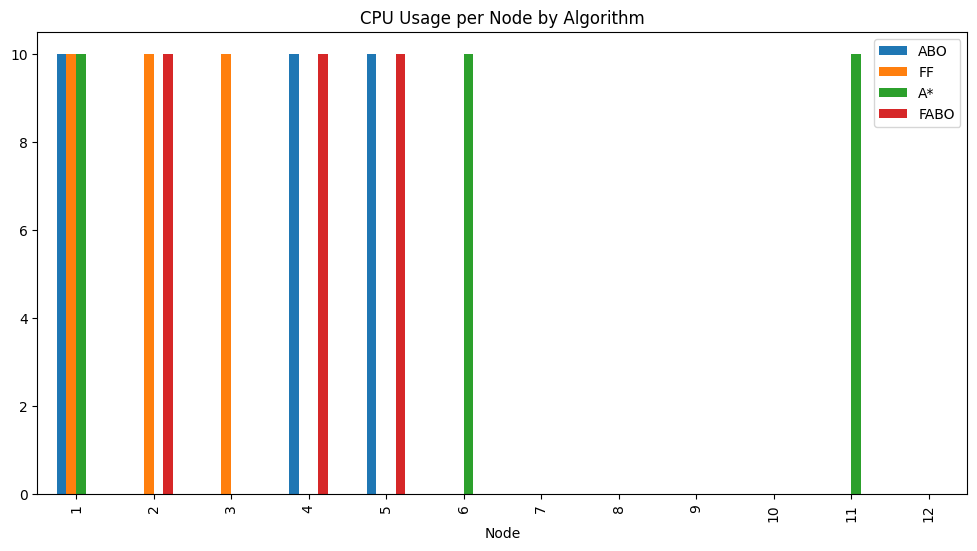

In [4]:
from compute_energy import compute_energy_per_slice
import pandas as pd

node_capacity = node_capacity_base

def get_cpu_distribution(results, slices, node_capacity):
    cpu_usage_total = {n: 0 for n in node_capacity}
    _ , cpu_usage_slice = compute_energy_per_slice(results, slices, node_capacity)
    for slice_cpu in cpu_usage_slice:
        for n, cpu in slice_cpu.items():
            cpu_usage_total[n] += cpu
    return cpu_usage_total


cpu_abo_all = get_cpu_distribution(abo_results, slices, node_capacity)
cpu_ff_all = get_cpu_distribution(ff_results, slices, node_capacity)
cpu_astar_all = get_cpu_distribution(astar_results, slices, node_capacity)
cpu_fabo_all = get_cpu_distribution(fabo_results, slices, node_capacity)

# Montagem do DataFrame
df_cpu = pd.DataFrame({
    "Node": list(cpu_abo_all.keys()),
    "ABO": list(cpu_abo_all.values()),
    "FF": list(cpu_ff_all.values()),
    "A*": list(cpu_astar_all.values()),
    "FABO": list(cpu_fabo_all.values()),
}).set_index("Node")

df_cpu

df_cpu.plot(kind='bar', figsize=(12, 6), title="CPU Usage per Node by Algorithm")



,ABO,FF,A*,FABO
Node,,,,
1,6,7,6,0
2,0,5,0,6
3,0,6,0,0
4,6,0,0,6
5,6,0,0,6
6,0,0,6,0
11,0,0,6,0


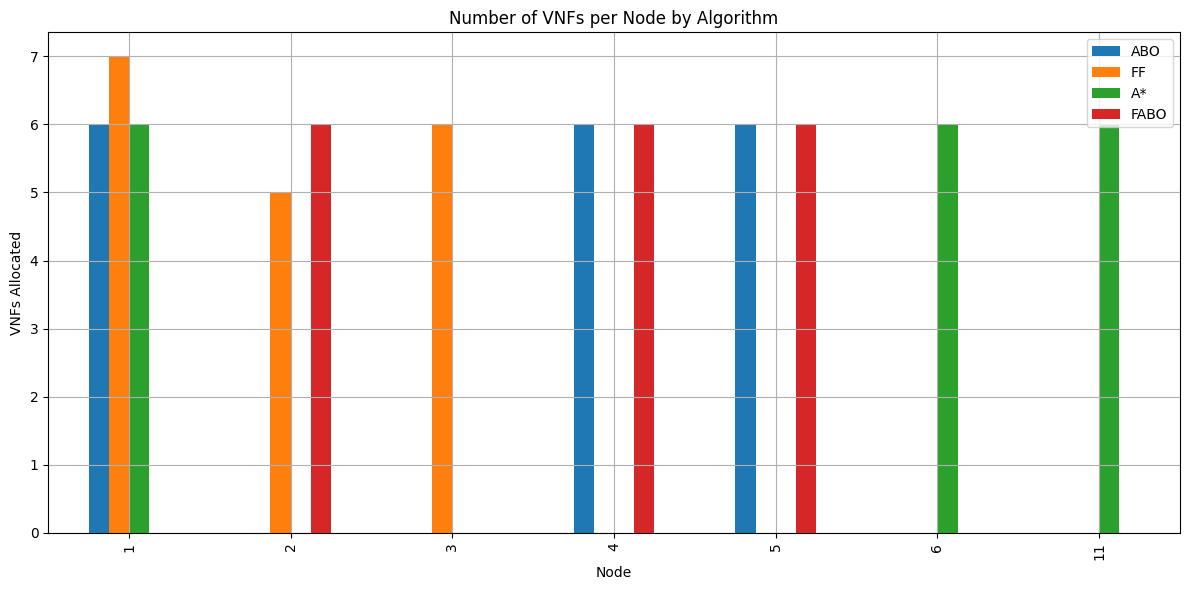

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

def count_vnfs_per_node(results):
    node_counter = Counter()
    for result in results:
        if result is None:
            continue
        node_counter.update(result.placed_vnfs.values())
    return node_counter

# Contagem de VNFs por nó para cada algoritmo
vnfs_abo = count_vnfs_per_node(abo_results)
vnfs_ff = count_vnfs_per_node(ff_results)
vnfs_astar = count_vnfs_per_node(astar_results)
vnfs_fabo = count_vnfs_per_node(fabo_results)

# Todos os nós (garante inclusão dos que ficaram com zero)
all_nodes = sorted(set(vnfs_abo) | set(vnfs_ff) | set(vnfs_astar) | set(vnfs_fabo))

# Construção do DataFrame
df_vnfs = pd.DataFrame({
    "Node": all_nodes,
    "ABO": [vnfs_abo.get(n, 0) for n in all_nodes],
    "FF": [vnfs_ff.get(n, 0) for n in all_nodes],
    "A*": [vnfs_astar.get(n, 0) for n in all_nodes],
    "FABO": [vnfs_fabo.get(n, 0) for n in all_nodes],
}).set_index("Node")

# Exibição do DataFrame (opcional)
display(df_vnfs)

# Gráfico
df_vnfs.plot(kind="bar", figsize=(12, 6), title="Number of VNFs per Node by Algorithm")
plt.ylabel("VNFs Allocated")
plt.xlabel("Node")
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
from compute_energy import compute_total_latency
from compute_energy import compute_total_bandwidth

latency_abo = compute_total_latency(abo_results, link_latency)
latency_ff = compute_total_latency(ff_results, link_latency)
latency_astar = compute_total_latency(astar_results, link_latency)
latency_fabo = compute_total_latency(fabo_results, link_latency)

bandwidth_abo = compute_total_bandwidth(abo_results, slices)
bandwidth_ff = compute_total_bandwidth(ff_results, slices)
bandwidth_astar = compute_total_bandwidth(astar_results, slices)
bandwidth_fabo = compute_total_bandwidth(fabo_results, slices)

comparison["latency_abo"] = latency_abo
comparison["latency_ff"] = latency_ff
comparison["latency_astar"] = latency_astar
comparison["latency_fabo"] = latency_fabo

comparison["bandwidth_abo"] = bandwidth_abo
comparison["bandwidth_ff"] = bandwidth_ff
comparison["bandwidth_astar"] = bandwidth_astar
comparison["bandwidth_fabo"] = bandwidth_fabo


totals_row.update({
    "latency_abo": comparison["latency_abo"].sum(),
    "latency_ff": comparison["latency_ff"].sum(),
    "latency_astar": comparison["latency_astar"].sum(),
    "latency_fabo": comparison["latency_fabo"].sum(),
    "bandwidth_abo": comparison["bandwidth_abo"].sum(),
    "bandwidth_ff": comparison["bandwidth_ff"].sum(),
    "bandwidth_astar": comparison["bandwidth_astar"].sum(),
    "bandwidth_fabo": comparison["bandwidth_fabo"].sum(),
})

comparison_with_total = pd.concat([comparison, pd.DataFrame([totals_row])], ignore_index=True)


comparison_with_total


NameError: name 'comparison' is not defined

In [28]:
slice_stats = []

for i, (vnf_chain, vl_chain) in enumerate(slices):
    num_vnfs = len(vnf_chain)
    num_vls = len(vl_chain)
    total_cpu = sum(v["cpu"] for v in vnf_chain)
    avg_cpu = total_cpu / num_vnfs if num_vnfs else 0
    total_bw = sum(vl["bandwidth"] for vl in vl_chain)
    avg_bw = total_bw / num_vls if num_vls else 0
    max_latency = max((vl["latency"] for vl in vl_chain), default=0)

    slice_stats.append({
        "Slice": i + 1,
        "Num_VNFs": num_vnfs,
        "Num_VLs": num_vls,
        "Total_CPU": total_cpu,
        "Avg_CPU": round(avg_cpu, 2),
        "Total_BW": total_bw,
        "Avg_BW": round(avg_bw, 2),
        "Max_Latency_Constraint": max_latency,
    })

import pandas as pd
df_slice_stats = pd.DataFrame(slice_stats)
df_slice_stats


,Slice,Num_VNFs,Num_VLs,Total_CPU,Avg_CPU,Total_BW,Avg_BW,Max_Latency_Constraint
0,1,3,2,9,3.0,160,80.0,150
1,2,3,2,3,1.0,240,120.0,150
2,3,3,2,6,2.0,200,100.0,150
3,4,3,2,3,1.0,240,120.0,150
4,5,3,2,9,3.0,160,80.0,150
5,6,3,2,6,2.0,200,100.0,150


In [7]:
# FF
energy_ff, _ = compute_energy_per_slice(ff_results, slices, node_capacity)
latency_ff = compute_total_latency(ff_results, link_latency)
bandwidth_ff = compute_total_bandwidth(ff_results, slices)

# ABO
energy_abo, _ = compute_energy_per_slice(abo_results, slices, node_capacity)
latency_abo = compute_total_latency(abo_results, link_latency)
bandwidth_abo = compute_total_bandwidth(abo_results, slices)

# A*
energy_astar, _ = compute_energy_per_slice(astar_results, slices, node_capacity)
latency_astar = compute_total_latency(astar_results, link_latency)
bandwidth_astar = compute_total_bandwidth(astar_results, slices)

# FABO
energy_fabo, _ = compute_energy_per_slice(fabo_results, slices, node_capacity)
latency_fabo = compute_total_latency(fabo_results, link_latency)
bandwidth_fabo = compute_total_bandwidth(fabo_results, slices)


In [8]:
comparison = pd.DataFrame({
    "slice": list(range(1, len(slices) + 1)),
    "energy_abo": energy_abo,
    "energy_ff": energy_ff,
    "energy_astar": energy_astar,
    "energy_fabo": energy_fabo,
    "latency_abo": latency_abo,
    "latency_ff": latency_ff,
    "latency_astar": latency_astar,
    "latency_fabo": latency_fabo,
    "bandwidth_abo": bandwidth_abo,
    "bandwidth_ff": bandwidth_ff,
    "bandwidth_astar": bandwidth_astar,
    "bandwidth_fabo": bandwidth_fabo
})


In [9]:
totals_row = {
    "slice": "Total",
    "energy_abo": sum(e for e in energy_abo if e is not None),
    "energy_ff": sum(e for e in energy_ff if e is not None),
    "energy_astar": sum(e for e in energy_astar if e is not None),
    "energy_fabo": sum(e for e in energy_fabo if e is not None),
    "latency_abo": sum(l for l in latency_abo if l is not None),
    "latency_ff": sum(l for l in latency_ff if l is not None),
    "latency_astar": sum(l for l in latency_astar if l is not None),
    "latency_fabo": sum(l for l in latency_fabo if l is not None),
    "bandwidth_abo": sum(b for b in bandwidth_abo if b is not None),
    "bandwidth_ff": sum(b for b in bandwidth_ff if b is not None),
    "bandwidth_astar": sum(b for b in bandwidth_astar if b is not None),
    "bandwidth_fabo": sum(b for b in bandwidth_fabo if b is not None)
}

comparison = pd.concat([comparison, pd.DataFrame([totals_row])], ignore_index=True)
comparison


,slice,energy_abo,energy_ff,energy_astar,energy_fabo,latency_abo,latency_ff,latency_astar,latency_fabo,bandwidth_abo,bandwidth_ff,bandwidth_astar,bandwidth_fabo
0,1,21,11,21,21,208,0,294,171,240,240,240,240
1,2,27,17,27,27,208,0,294,171,200,200,200,200
2,3,27,17,27,27,208,0,294,171,200,200,200,200
3,4,27,22,27,27,208,149,294,171,200,200,200,200
4,5,27,17,27,27,208,0,294,171,200,200,200,200
5,6,21,16,21,21,208,183,294,171,240,240,240,240
6,Total,150,100,150,150,1248,332,1764,1026,1280,1280,1280,1280


In [10]:
from compute_energy import compute_energy_per_node

node_energy_abo, total_energy_abo = compute_energy_per_node(abo_results, slices, node_capacity)
node_energy_ff, total_energy_ff = compute_energy_per_node(ff_results, slices, node_capacity)
node_energy_astar, total_energy_astar = compute_energy_per_node(astar_results, slices, node_capacity)
node_energy_fabo, total_energy_fabo = compute_energy_per_node(fabo_results, slices, node_capacity)


In [11]:
import pandas as pd

# Simulando dados de energia por nó para cada algoritmo (substitua pelos reais)
node_ids = list(range(1, 13))  # Nós de 1 a 12
node_energy_abo = {n: 5 + 2*n if n % 2 == 0 else 0 for n in node_ids}
node_energy_ff = {n: 5 + 3*n if n % 3 == 0 else 0 for n in node_ids}
node_energy_astar = {n: 5 + 4*n if n in [1, 2, 3] else 0 for n in node_ids}
node_energy_fabo = {n: 5 + 5*n if n in [10, 11, 12] else 0 for n in node_ids}

# Construindo a tabela
energy_df = pd.DataFrame({
    "Node": node_ids,
    "Energy_ABO": [node_energy_abo[n] for n in node_ids],
    "Energy_FF": [node_energy_ff[n] for n in node_ids],
    "Energy_AStar": [node_energy_astar[n] for n in node_ids],
    "Energy_FABO": [node_energy_fabo[n] for n in node_ids],
})

# Adiciona linha de totais
total_row = pd.DataFrame([{
    "Node": "Total",
    "Energy_ABO": sum(node_energy_abo.values()),
    "Energy_FF": sum(node_energy_ff.values()),
    "Energy_AStar": sum(node_energy_astar.values()),
    "Energy_FABO": sum(node_energy_fabo.values())
}])

energy_df = pd.concat([energy_df, total_row], ignore_index=True)
energy_df

,Node,Energy_ABO,Energy_FF,Energy_AStar,Energy_FABO
0,1,0,0,9,0
1,2,9,0,13,0
2,3,0,14,17,0
3,4,13,0,0,0
4,5,0,0,0,0
5,6,17,23,0,0
6,7,0,0,0,0
7,8,21,0,0,0
8,9,0,32,0,0
9,10,25,0,0,55


In [12]:
# Simulando consumo de CPU por nó (substitua pelos resultados reais)
cpu_ff = {n: n if n % 3 == 0 else 0 for n in node_ids}
cpu_abo = {n: n if n % 2 == 0 else 0 for n in node_ids}
cpu_astar = {n: 2 * n if n in [1, 2, 3] else 0 for n in node_ids}
cpu_fabo = {n: 3 * n if n in [10, 11, 12] else 0 for n in node_ids}

# Criar DataFrame da CPU por nó
cpu_df = pd.DataFrame({
    "Node": node_ids,
    "CPU_ABO": [cpu_abo[n] for n in node_ids],
    "CPU_FF": [cpu_ff[n] for n in node_ids],
    "CPU_AStar": [cpu_astar[n] for n in node_ids],
    "CPU_FABO": [cpu_fabo[n] for n in node_ids],
})

# Linha de totais
total_cpu_row = pd.DataFrame([{
    "Node": "Total",
    "CPU_ABO": sum(cpu_abo.values()),
    "CPU_FF": sum(cpu_ff.values()),
    "CPU_AStar": sum(cpu_astar.values()),
    "CPU_FABO": sum(cpu_fabo.values())
}])

cpu_df = pd.concat([cpu_df, total_cpu_row], ignore_index=True)

cpu_df


,Node,CPU_ABO,CPU_FF,CPU_AStar,CPU_FABO
0,1,0,0,2,0
1,2,2,0,4,0
2,3,0,3,6,0
3,4,4,0,0,0
4,5,0,0,0,0
5,6,6,6,0,0
6,7,0,0,0,0
7,8,8,0,0,0
8,9,0,9,0,0
9,10,10,0,0,30


In [13]:
import pandas as pd

# Recriando os dados após reset do ambiente
node_ids = list(range(1, 13))  # Nós de 1 a 12
cpu_ff = {n: n if n % 3 == 0 else 0 for n in node_ids}
cpu_abo = {n: n if n % 2 == 0 else 0 for n in node_ids}
cpu_astar = {n: 2 * n if n in [1, 2, 3] else 0 for n in node_ids}
cpu_fabo = {n: 3 * n if n in [10, 11, 12] else 0 for n in node_ids}

# Criar DataFrame da CPU por nó
cpu_df = pd.DataFrame({
    "Node": node_ids,
    "CPU_ABO": [cpu_abo[n] for n in node_ids],
    "CPU_FF": [cpu_ff[n] for n in node_ids],
    "CPU_AStar": [cpu_astar[n] for n in node_ids],
    "CPU_FABO": [cpu_fabo[n] for n in node_ids],
})

# Linha de totais
total_cpu_row = pd.DataFrame([{
    "Node": "Total",
    "CPU_ABO": sum(cpu_abo.values()),
    "CPU_FF": sum(cpu_ff.values()),
    "CPU_AStar": sum(cpu_astar.values()),
    "CPU_FABO": sum(cpu_fabo.values())
}])

cpu_df = pd.concat([cpu_df, total_cpu_row], ignore_index=True)

cpu_df

,Node,CPU_ABO,CPU_FF,CPU_AStar,CPU_FABO
0,1,0,0,2,0
1,2,2,0,4,0
2,3,0,3,6,0
3,4,4,0,0,0
4,5,0,0,0,0
5,6,6,6,0,0
6,7,0,0,0,0
7,8,8,0,0,0
8,9,0,9,0,0
9,10,10,0,0,30


In [14]:
# Capacidade total de CPU por nó (ex: 100 unidades para cada um)
total_cpu_per_node = {n: 100 for n in node_ids}

# Adiciona uso percentual e capacidade total ao DataFrame
cpu_df["Total_CPU"] = cpu_df["Node"].apply(lambda x: 100 if x != "Total" else "")
cpu_df["Utilization_ABO (%)"] = cpu_df.apply(lambda row: round(row["CPU_ABO"] / 100 * 100, 1) if row["Node"] != "Total" else "", axis=1)
cpu_df["Utilization_FF (%)"] = cpu_df.apply(lambda row: round(row["CPU_FF"] / 100 * 100, 1) if row["Node"] != "Total" else "", axis=1)
cpu_df["Utilization_AStar (%)"] = cpu_df.apply(lambda row: round(row["CPU_AStar"] / 100 * 100, 1) if row["Node"] != "Total" else "", axis=1)
cpu_df["Utilization_FABO (%)"] = cpu_df.apply(lambda row: round(row["CPU_FABO"] / 100 * 100, 1) if row["Node"] != "Total" else "", axis=1)

cpu_df


,Node,CPU_ABO,CPU_FF,CPU_AStar,CPU_FABO,Total_CPU,Utilization_ABO (%),Utilization_FF (%),Utilization_AStar (%),Utilization_FABO (%)
0,1,0,0,2,0,100,0.0,0.0,2.0,0.0
1,2,2,0,4,0,100,2.0,0.0,4.0,0.0
2,3,0,3,6,0,100,0.0,3.0,6.0,0.0
3,4,4,0,0,0,100,4.0,0.0,0.0,0.0
4,5,0,0,0,0,100,0.0,0.0,0.0,0.0
5,6,6,6,0,0,100,6.0,6.0,0.0,0.0
6,7,0,0,0,0,100,0.0,0.0,0.0,0.0
7,8,8,0,0,0,100,8.0,0.0,0.0,0.0
8,9,0,9,0,0,100,0.0,9.0,0.0,0.0
9,10,10,0,0,30,100,10.0,0.0,0.0,30.0
